In [1]:
! pip install -qU sagemaker

In [27]:
from pandas import read_csv
from sklearn.model_selection import train_test_split
import math
import pandas as pd
import numpy as np
import sagemaker
from sagemaker.tensorflow import TensorFlow

In [3]:
# load the dataset
path = "s3://nguyen-viet-ceu2023/pokemon_showdown_ml_data/raw_data/20231209_game_state.csv"
df = read_csv(path)

/home/ec2-user/anaconda3/envs/python3/lib/python3.10/site-packages/fsspec/registry.py:272: UserWarning: Your installed version of s3fs is very old and known to cause
severe performance issues, see also https://github.com/dask/dask/issues/10276

To fix, you should specify a lower version bound on s3fs, or
update the current installation.

  warnings.warn(s3_msg)


In [4]:
# create label & feature data
features = df.copy()
labels = features.pop('p1_win')

In [5]:
# ensure all data are floating point values
features = features.astype('float32')
labels = labels.astype('float32')

In [6]:
# split into train and test datasets
X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=12)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(38607, 214) (9652, 214) (38607,) (9652,)


In [7]:
# Reserve 200 samples for validation
X_val = X_train[-200:]
y_val = y_train[-200:]
X_train = X_train[:-200]
y_train = y_train[:-200]

In [8]:
# Use 'csv' format to store the data
X_train.to_csv('train_data.csv', index=False)
y_train.to_csv('train_label.csv', index=False)
X_test.to_csv('test_data.csv', index=False)
y_test.to_csv('test_label.csv', index=False)
X_val.to_csv('val_data.csv', index=False)
y_val.to_csv('val_label.csv', index=False)

In [9]:
# upload train, testing and validation data to S3
import sagemaker, boto3, os
bucket = "nguyen-viet-ceu2023"
prefix = "pokemon_showdown_ml_data"

boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/train_data.csv')).upload_file('train_data.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/train_label.csv')).upload_file('train_label.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/test_data.csv')).upload_file('test_data.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/test_label.csv')).upload_file('test_label.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/val_data.csv')).upload_file('val_data.csv')
boto3.Session().resource('s3').Bucket(bucket).Object(
    os.path.join(prefix, 'data/val_label.csv')).upload_file('val_label.csv')

In [10]:
# check if the CSV files are successfully uploaded to the S3 bucket
! aws s3 ls {bucket}/{prefix}/data --recursive

2023-12-16 15:05:31    8420477 pokemon_showdown_ml_data/data/test_data.csv
2023-12-16 15:05:32      38615 pokemon_showdown_ml_data/data/test_label.csv
2023-12-16 15:05:30   33494843 pokemon_showdown_ml_data/data/train_data.csv
2023-12-16 15:05:31     153635 pokemon_showdown_ml_data/data/train_label.csv
2023-12-16 15:05:32     177809 pokemon_showdown_ml_data/data/val_data.csv
2023-12-16 15:05:32        807 pokemon_showdown_ml_data/data/val_label.csv


In [11]:
# retrieving the basic information from your current SageMaker session
import sagemaker

region = sagemaker.Session().boto_region_name
print("AWS Region: {}".format(region))

role = sagemaker.get_execution_role()
print("RoleArn: {}".format(role))

AWS Region: eu-west-1
RoleArn: arn:aws:iam::870137400553:role/service-role/AmazonSageMaker-ExecutionRole-20231215T194361


In [12]:
# output path
s3_output_location='s3://{}/{}/{}'.format(bucket, prefix, 'model')

# create estimator
tf_estimator = TensorFlow(
    entry_point="ps_tensorflow_training.py",
    role=role,
    output_path=s3_output_location,
    instance_count=1,
    instance_type="ml.c5.xlarge",
    framework_version="2.13.0",
    py_version="py310",
    hyperparameters={'epochs' : 100, 'batch_size' : 32},
    script_mode=True
)

# Run training job
tf_estimator.fit({'train': 's3://nguyen-viet-ceu2023/pokemon_showdown_ml_data/data/'})

INFO:sagemaker.image_uris:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating training-job with name: tensorflow-training-2023-12-16-15-06-08-559


Using provided s3_resource
2023-12-16 15:06:08 Starting - Starting the training job...
2023-12-16 15:06:23 Starting - Preparing the instances for training......
2023-12-16 15:07:19 Downloading - Downloading input data...
2023-12-16 15:08:04 Downloading - Downloading the training image...
2023-12-16 15:08:30 Training - Training image download completed. Training in progress..2023-12-16 15:08:34.292092: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-12-16 15:08:36,423 sagemaker-training-toolkit INFO     Imported framework sagemaker_tensorflow_container.training
2023-12-16 15:08:36,424 sagemaker-training-toolkit INFO     No GPUs detected (normal if no gpus installed)
2023-12-16 15:08:36,425 sagemaker-training-toolkit INFO     No Neurons detected (norma

In [13]:
from sagemaker.serializers import CSVSerializer

# Deploy the Model to SageMaker Hosting Services
ps_game_state_preditor = tf_estimator.deploy(
    initial_instance_count=1,
    instance_type='ml.t2.medium',
    serializer=CSVSerializer()
)
ps_game_state_preditor.endpoint_name

INFO:sagemaker.tensorflow.model:image_uri is not presented, retrieving image_uri based on instance_type, framework etc.
INFO:sagemaker:Creating model with name: tensorflow-training-2023-12-16-15-18-39-341
INFO:sagemaker:Creating endpoint-config with name tensorflow-training-2023-12-16-15-18-39-341
INFO:sagemaker:Creating endpoint with name tensorflow-training-2023-12-16-15-18-39-341


-----!

'tensorflow-training-2023-12-16-15-18-39-341'

In [23]:
# evaluate the deployed model
predictions = ps_game_state_preditor.predict(X_test)
pred_df = pd.DataFrame.from_dict(predictions)
pred_df['pred_val'] = pred_df.predictions.apply(lambda x: x[0])
pred_df

,predictions,pred_val
0,[0.575547338],0.575547
1,[0.929988503],0.929989
2,[2.37245263e-06],0.000002
3,[0.999972641],0.999973
4,[0.534211576],0.534212
...,...,...
9647,[0.0995442346],0.099544
9648,[1.0],1.000000
9649,[1.0],1.000000
9650,[0.248534396],0.248534


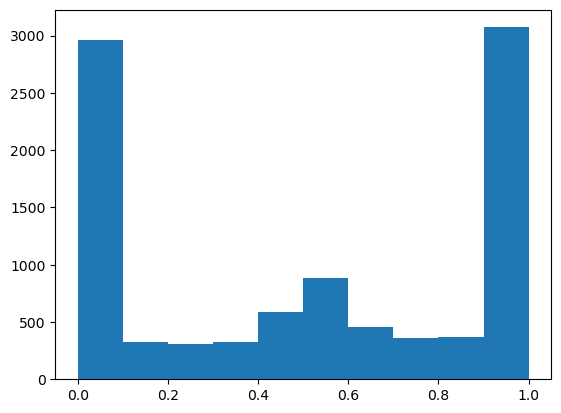

In [24]:
import matplotlib.pyplot as plt

# Visualize the distribution of the prediction results
plt.hist(pred_df.pred_val)
plt.show()

In [29]:
import sklearn

# output confusion metrics and classification report with a cutoff of 0.5
cutoff=0.5
print(sklearn.metrics.confusion_matrix(y_test, np.where(pred_df.pred_val > cutoff, 1, 0)))
print(sklearn.metrics.classification_report(y_test, np.where(pred_df.pred_val > cutoff, 1, 0)))

[[3823  993]
 [ 682 4154]]
              precision    recall  f1-score   support

         0.0       0.85      0.79      0.82      4816
         1.0       0.81      0.86      0.83      4836

    accuracy                           0.83      9652
   macro avg       0.83      0.83      0.83      9652
weighted avg       0.83      0.83      0.83      9652


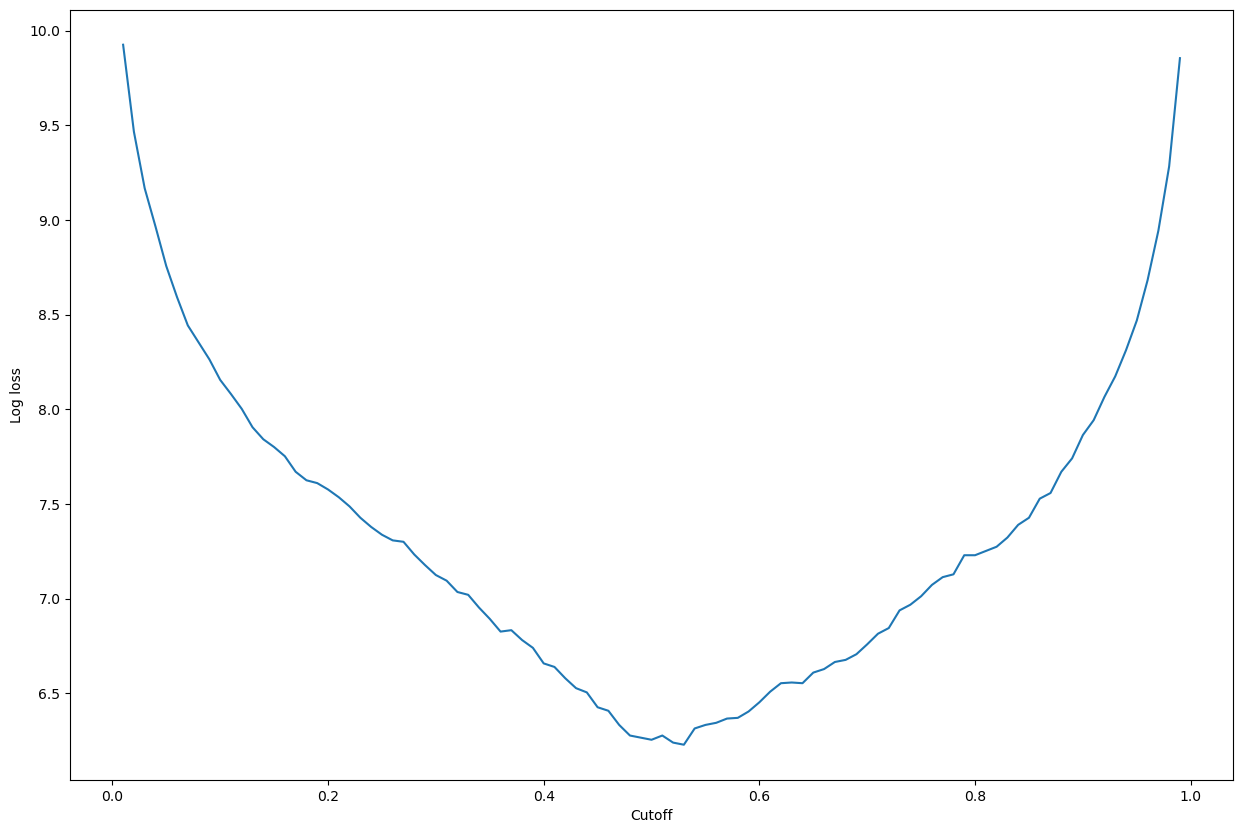

In [30]:
# find the best cutoff by calculating the log loss values (-(y*log(p)+(1-y)log(1-p)), 
# where y is the true label and p is a probability estimate of the corresponding test sample
cutoffs = np.arange(0.01, 1, 0.01)
log_loss = []
for c in cutoffs:
    log_loss.append(
        sklearn.metrics.log_loss(y_test, np.where(pred_df.pred_val > c, 1, 0))
    )

plt.figure(figsize=(15,10))
plt.plot(cutoffs, log_loss)
plt.xlabel("Cutoff")
plt.ylabel("Log loss")
plt.show()

In [31]:
print(
    'Log loss is minimized at a cutoff of ', cutoffs[np.argmin(log_loss)], 
    ', and the log loss value at the minimum is ', np.min(log_loss)
)

Log loss is minimized at a cutoff of  0.53 , and the log loss value at the minimum is  6.228845198202177
